# Test Notebook to work on configurations without needing to train/test every time

First of all, we need to train the RNNDisaggregator using the train data. For this example, both train and test data are consumption data of the microwave of the first REDD building.

In [1]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet

train = DataSet('C:/Users/zebzi/Documents/School/Senior_Year/EE_4951W/SeniorProject/SeniorDataset/h5_files/RNN_test_NOT12Hour.h5')
# except:
#     train = DataSet('/SeniorDataset/h5_files/Zeb_test.h5')
    
train.set_window(start="12-12-2021", end="2-2-2022")
train_elec = train.buildings[1].elec

Next, we need to define the disaggregator model.

In [2]:
from rnndisaggregator import RNNDisaggregator
rnn = RNNDisaggregator()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Then train the model. We need to input the train data as well as their sample period. Also, we need to pass the desired number of training epochs. Finally, save the model for later use.

In [3]:
meter_key = 'kettle'
# train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
# train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

train_meter = train_elec.submeters()[meter_key]
train_mains = train_elec.mains()
print(train_elec)

rnn.train(train_mains, train_meter, epochs=5, sample_period=1)
rnn.export_model("model-Zeb_test.h5")
# rnn.import_model("model-Zeb_test.h5")

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='Senior Design Dataset', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='Senior Design Dataset', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=1, dataset='Senior Design Dataset', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=4, building=1, dataset='Senior Design Dataset', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=5, building=1, dataset='Senior Design Dataset', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=6, building=1, dataset='Senior Design Dataset', appliances=[Appliance(type='toaster', instance=1)])
  ElecMeter(instance=7, building=1, dataset='Senior Design Dataset', appliances=[Appliance(type='hair dryer', instance=1)])
)
Epoch 1/5
79/79 [==============================] - 9s 114ms/step - loss: 0.0025
Epoch 2/5
79/79 [==============================] - 9s 108ms/step - loss: 

Now that the model is trained, we can use it to disaggregate energy data. Let's test it on the rest of the data from building 1.

First we use the model to predict the microwave consumption. The results are saved automatically in a .h5 datastore.

In [4]:
# Configure the <test> dataset and set the test_mains variable
# test = DataSet('C:/Users/zebzi/Documents/School/Senior_Year/EE_4951W/SeniorProject/SeniorDataset/h5_files/RNN_test_12Hour.h5')
test = DataSet("ukdale.h5")

test.set_window(start="1-1-2014", end="10-1-2014")
# test.set_window(start= "12-12-2021", end="2-2-2022")
print(test.buildings[1].elec)
test_elec = test.buildings[1].elec
# test_mains = test_elec.mains().all_meters()[0]
test_mains = test_elec.mains()
# print(test_mains)



MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])
  ElecMeter(instance=4, building=1, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1), Appliance(type='laptop computer', instance=3)])
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)])
  ElecMeter(instance=9, building=1, dataset='UK-DALE', appliances=[Appliance(type='HTPC', instance=1)])
  Ele

In [6]:
try:
    disag_filename = 'disag-out.h5' # The filename of the resulting datastore
    from nilmtk.datastore import HDFDataStore
    output = HDFDataStore(disag_filename, 'w')

    # test_mains: The aggregated signal meter
    # output: The output datastore
    # train_meter: This is used in order to copy the metadata of the train meter into the datastore
    rnn.disaggregate(test_mains, output, train_meter, sample_period=1)
    output.close()
    # output = HDFDataStore(disag_filename, 'r') why is this code here?
except:
    output.close()


New sensible chunk: 5310216
41487/41487 [==============================] - 1140s 27ms/step
New sensible chunk: 3517
28/28 [==============================] - 1s 29ms/step
New sensible chunk: 3442
27/27 [==============================] - 1s 30ms/step
New sensible chunk: 3438
27/27 [==============================] - 1s 31ms/step
New sensible chunk: 12052026
94157/94157 [==============================] - 2741s 29ms/step
New sensible chunk: 5572014
43532/43532 [==============================] - 1323s 30ms/step
New sensible chunk: 582231
4549/4549 [==============================] - 159s 35ms/step


Let's plot the results and compare them to the ground truth signal.

**Note:** Calling plot this way, downsamples the signal to reduce computing time. To plot the entire signal call
```
predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()
```

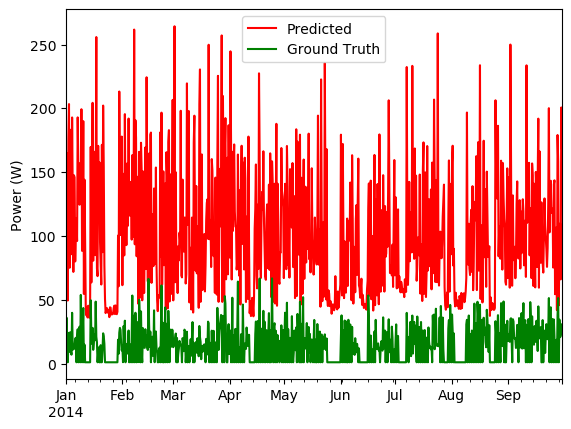

In [7]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['kettle']
ground_truth = test_elec['kettle']

import matplotlib.pyplot as plt
predicted.plot(plot_kwargs={'color':'red', 'label':'Predicted'})
ground_truth.plot(plot_kwargs={'color':'green', 'label':'Ground Truth'})
plt.show()

Finally let's see the metric results.

In [8]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 1.0
============ Precision: 0.8614071531292847
============ Accuracy: 0.8614071531292847
============ F1 Score: 0.9255440451930567
============ Relative error in total energy: 0.9791219199044232
============ Mean absolute error(in Watts): 103.40860244926523


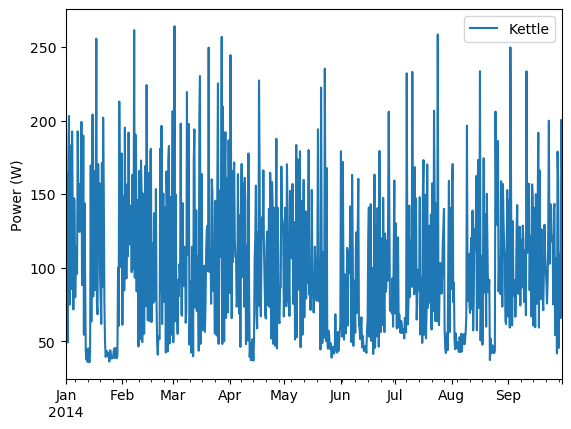

In [9]:
predicted.plot()

In [ ]:
ground_truth.plot()